<a href="https://colab.research.google.com/github/rajatgoyal715/SDCND-P2-AdvancedLaneLines/blob/master/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Finding Lane Lines - Advanced

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. (D)

2. Apply a distortion correction to raw images. (D)

3. Use color transforms, gradients, etc., to create a thresholded binary image. (D)

4. Apply a perspective transform to rectify binary image ("birds-eye view"). (D)

5. Detect lane pixels and fit to find the lane boundary.

6. Determine the curvature of the lane and vehicle position with respect to center.

7. Warp the detected lane boundaries back onto the original image.

8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position



### Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
project_path = '/content/gdrive/My Drive/Colab Notebooks/SDCND/P2-AdvancedLaneLines'

### Import Packages

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

### Define Undistort function and Find Corners and Camera Calibration

In [0]:
def undistort(img):
    global objpoints
    global imgpoints
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None)
    return undist

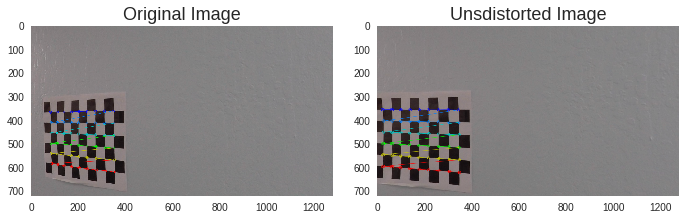

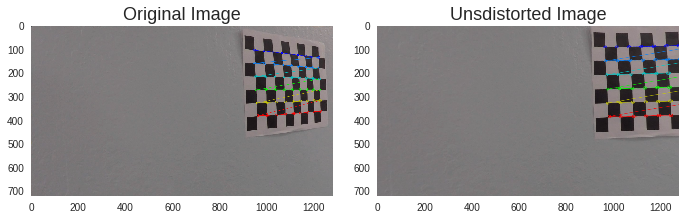

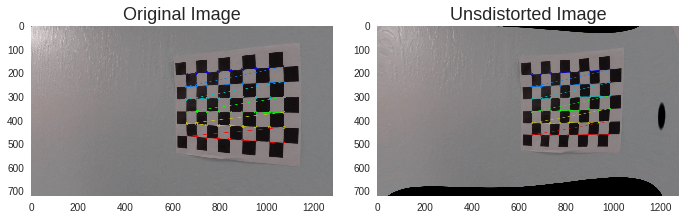

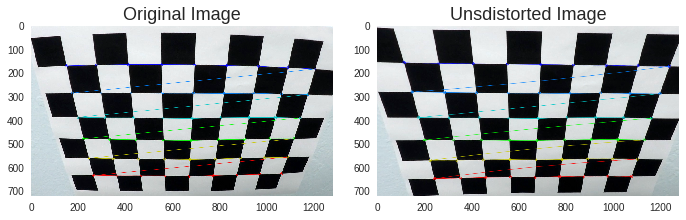

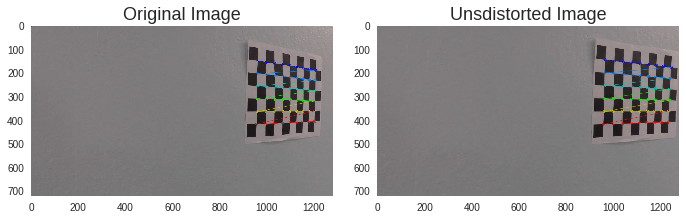

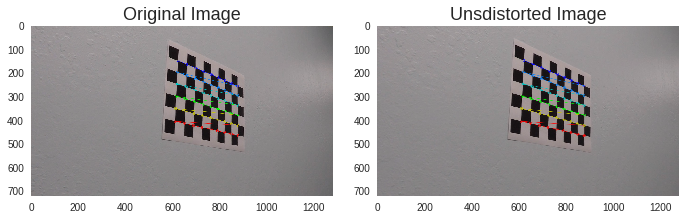

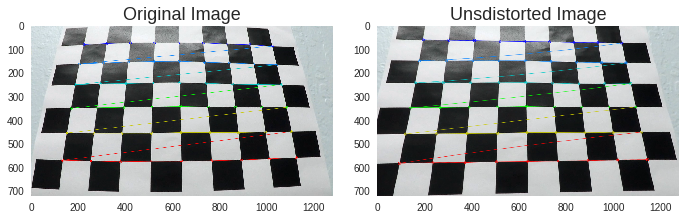

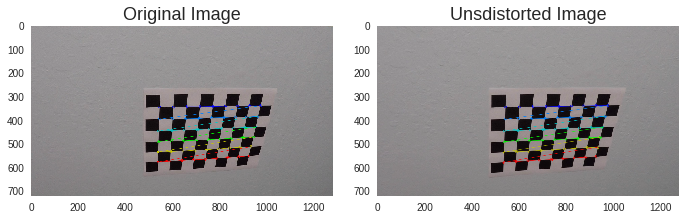

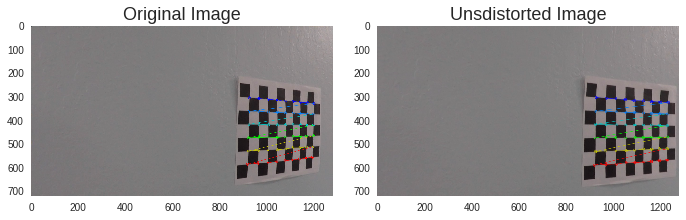

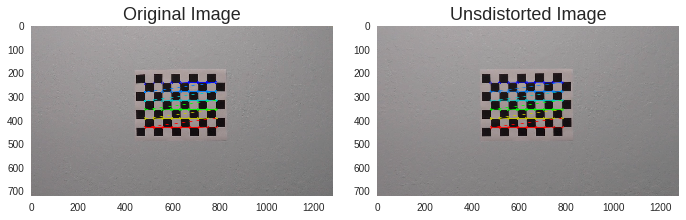

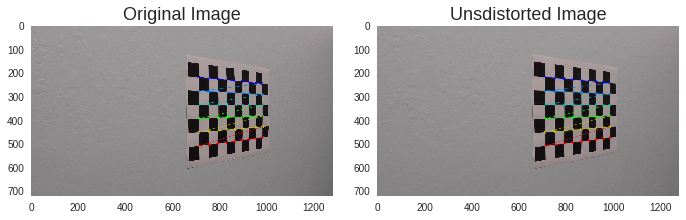

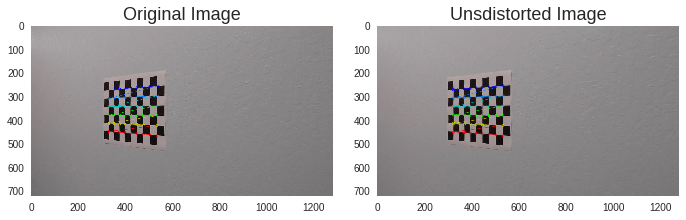

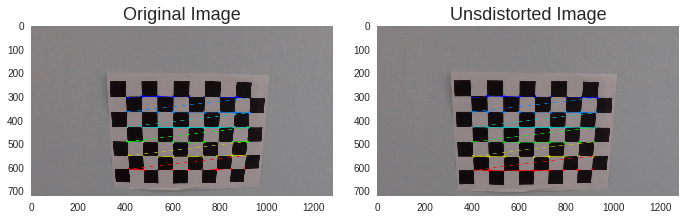

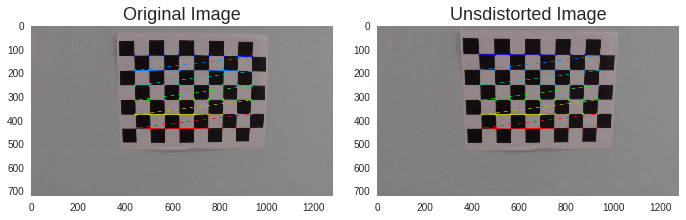

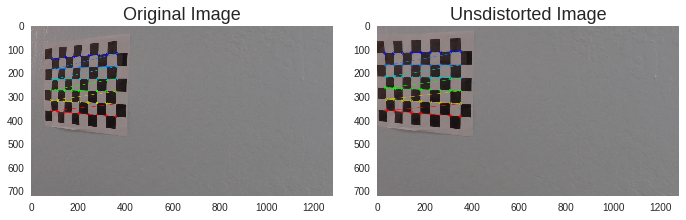

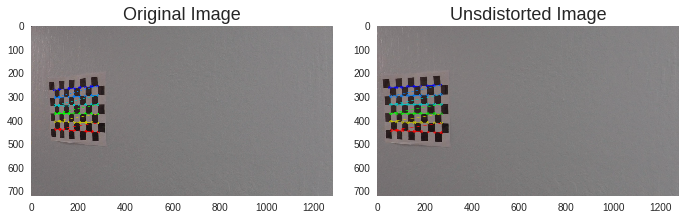

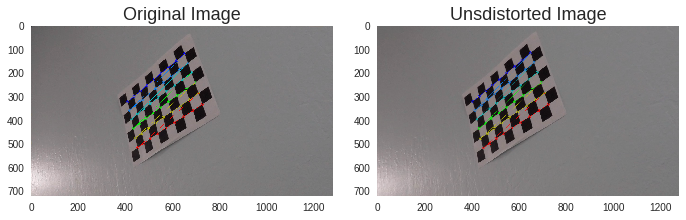

In [0]:
# Store object points and image points
objpoints = []
imgpoints = []

nx = 9
ny = 6

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Read images
images = glob.glob(F"{project_path}/camera_cal/calibration*.jpg");

for image_path in images:
    # Read image
    image = cv2.imread(image_path)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found corners, append obejct points and image points
    if ret == True:
        # Append corners
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw the corners
        image =  cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        
        # Undistort the image
        undist = undistort(image)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(image)
        ax1.grid(False)
        ax1.set_title('Original Image', fontsize=18)

        ax2.imshow(undist)
        ax2.grid(False)
        ax2.set_title('Unsdistorted Image', fontsize=18)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Undistort Test Images

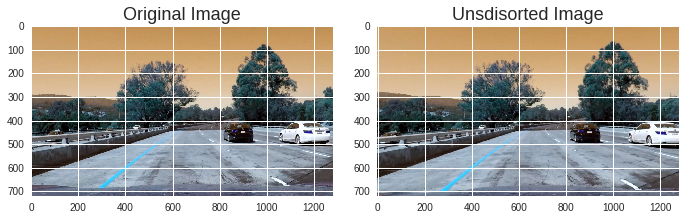

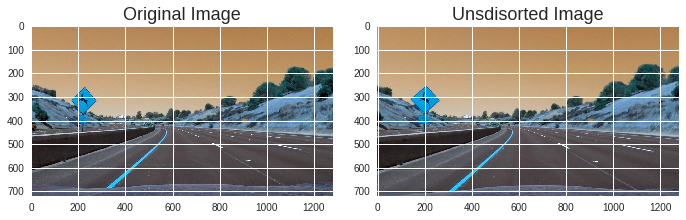

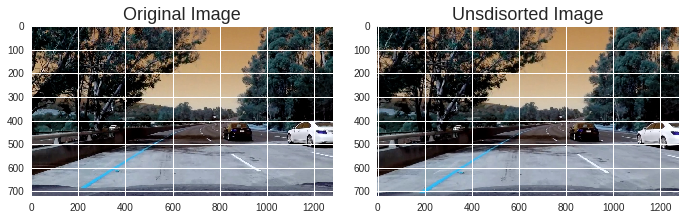

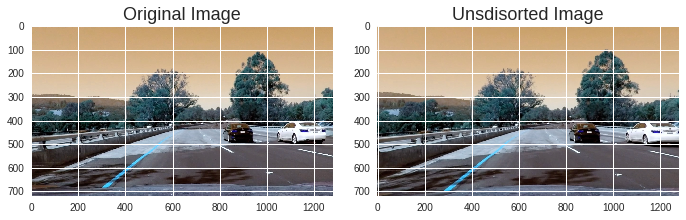

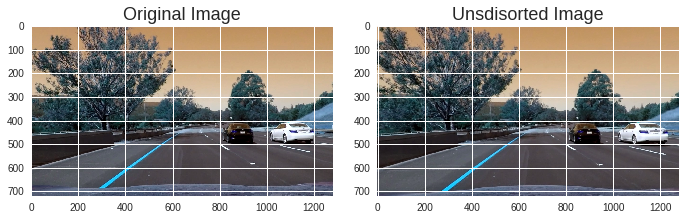

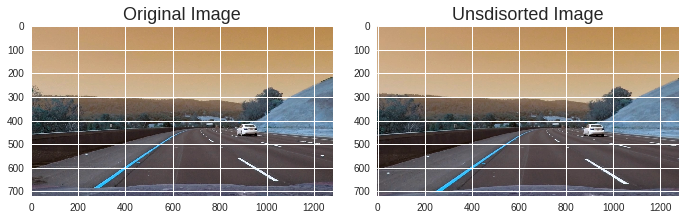

In [0]:
images = glob.glob(F"{project_path}/test_images/test*.jpg")
for image_path in images:
    # Read image
    image = cv2.imread(image_path)
    undist = undistort(image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=18)
    
    ax2.imshow(undist)
    ax2.set_title('Unsdisorted Image', fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Thresholding

In [0]:
def bin_threshold(img):
    
    # separating out the S channel and L channel in HLS space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    #R and B channel in RGB space
    r_channel = img[:,:,0]
    
    # b from lab
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
    
    # Grayscale image
    # color info lost
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8( 255 * sobelx / np.max(sobelx) )

    # Threshold gradient
    thresh_min = 50
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold channels
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    l_thresh_min = 220
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    b_thresh_min = 170
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    r_thresh_min = 230
    r_thresh_max = 255
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    
    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) | (l_binary == 1) | (b_binary == 1) | (r_binary == 1)] = 1
    
    # Combine the two binary thresholds
    comb_binary = np.zeros_like(sxbinary)
    comb_binary[(color_binary == 1) | (sxbinary == 1)] = 1
    
    return comb_binary

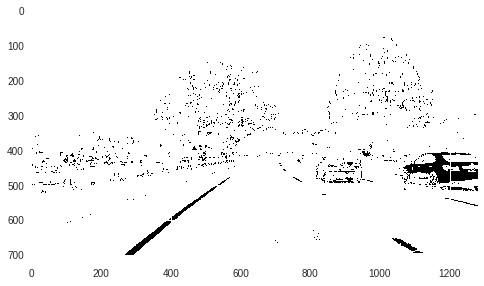

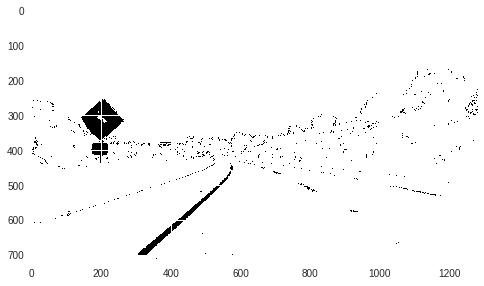

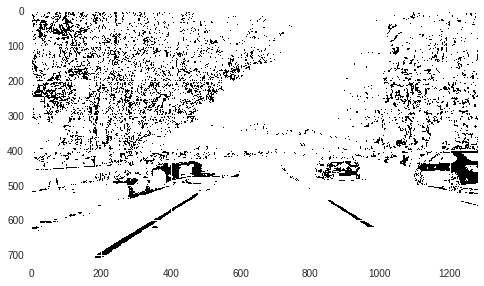

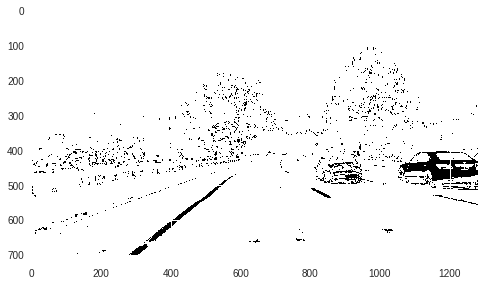

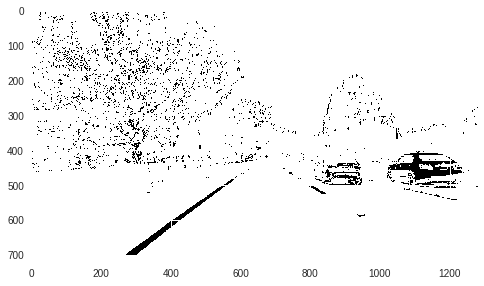

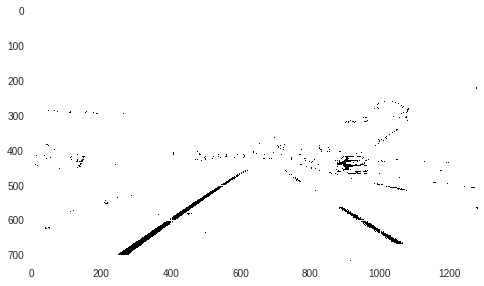

<Figure size 576x396 with 0 Axes>

In [0]:
images = glob.glob(F"{project_path}/test_images/test*.jpg")
for image_path in images:
    # Read image
    image =  cv2.imread(image_path)
    
    # Undistort
    undist = undistort(image)
    
    # Thresholding
    img_binary = bin_threshold(undist)
    
    tmp = np.dstack((img_binary, img_binary, img_binary))
    tmp[:,:,2:] = 0
    tmp = (255*tmp/np.max(tmp)).astype(np.uint8)
    plt.imshow(img_binary)
    plt.figure()

### Perspective Transform

In [0]:
def pers(img):
    
    # Set source and destination points
    src = np.float32([(202,720),(1099,720),(705,463),(580,463)])
    dst = np.float32([(202,720),(1099,720),(1099,0),(202,0)])
    
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    
    return warped

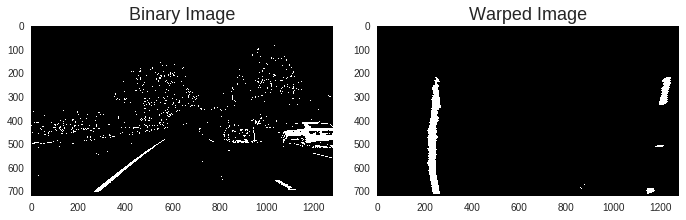

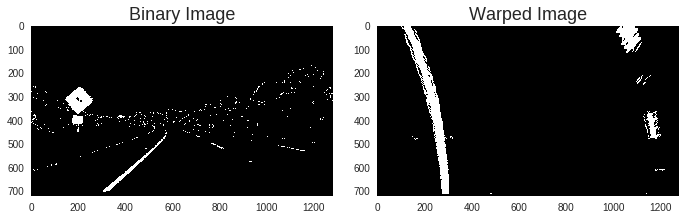

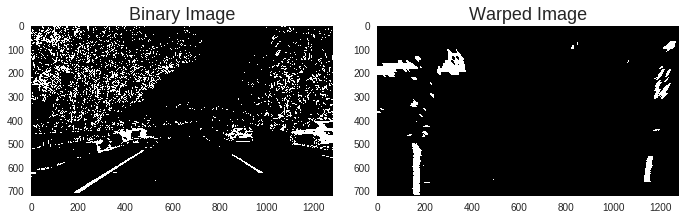

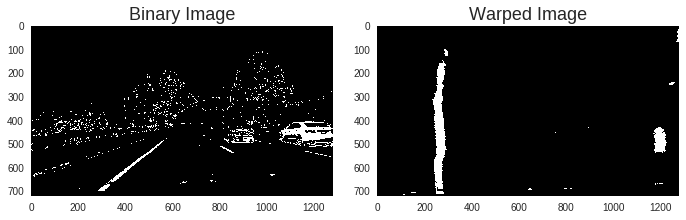

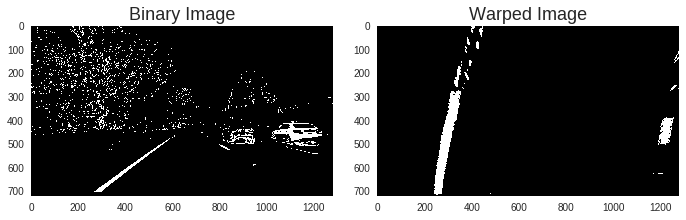

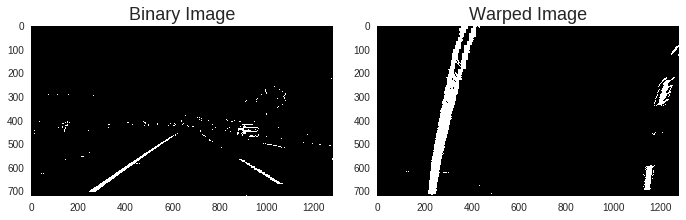

In [0]:
images = glob.glob(F"{project_path}/test_images/test*.jpg")

warped_images = []

for image_path in images:
    # Read a raw image
    img = cv2.imread(image_path)
    
    # Undistort raw image
    undist = undistort(img)
    
    # Apply Threshold
    binary = bin_threshold(undist)
    
    # Perform Perspective transform
    warped = pers(binary)
    
    # Save Warped Images
    warped_images.append(warped)
    tmp = np.dstack((warped,warped,warped))
    tmp = (255*tmp/np.max(tmp)).astype(np.uint8)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(binary,cmap='gray')
    ax1.set_title('Binary Image', fontsize=18)
    ax1.grid(False)
    
    ax2.imshow(warped,cmap='gray')
    ax2.set_title('Warped Image', fontsize=18)
    ax2.grid(False)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

### Detect Lane Lines

In [0]:
def find_lane_pixels(warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped,warped, warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(warped):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fit,right_fit

### Fit polynomial

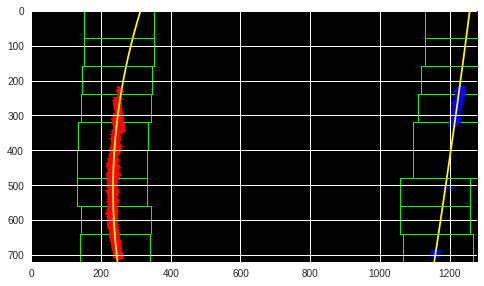

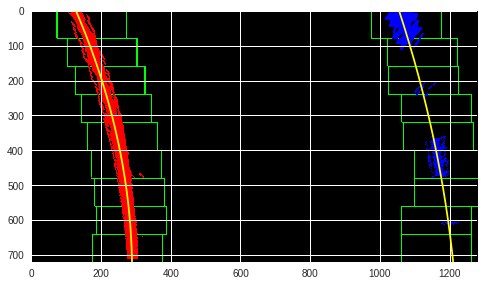

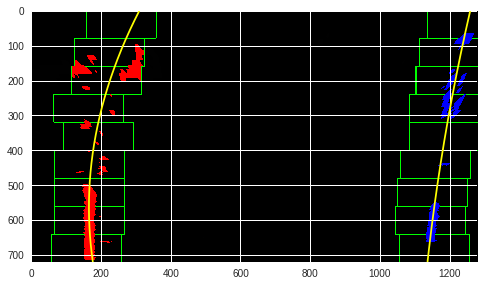

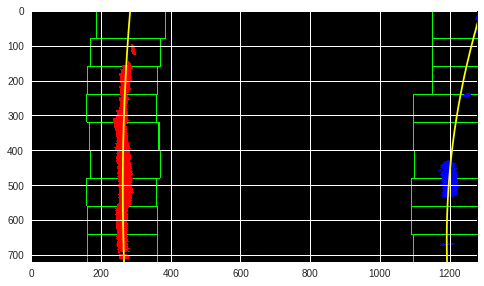

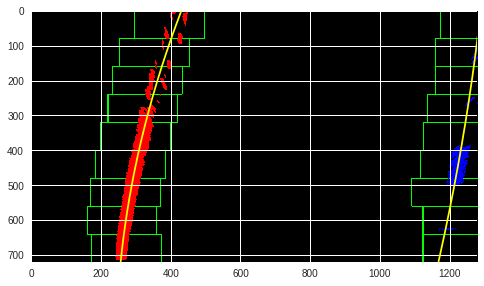

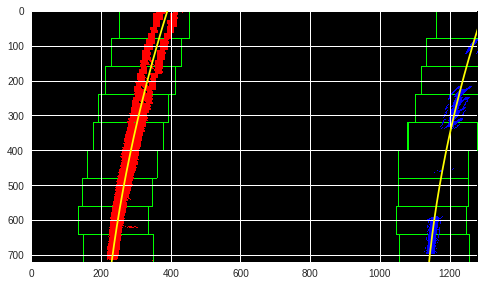

<Figure size 576x396 with 0 Axes>

In [0]:
# Fit polynomial and show lane lines
for img in warped_images:
    lane_lines,left_fit,right_fit = fit_polynomial(img)
    plt.imshow(lane_lines)
    plt.figure()

### Determine Radius of Curvature

In [0]:
def measure_curvature(x_val,warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/896 # meteres per pixel in x dimension
    
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_val = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    y_eval = np.max(y_val)
    
    # Calculation of R_curve (radius of curvature)
    fit_cr = np.polyfit(y_val*ym_per_pix, x_val*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
       
    return curverad

### Find Lane Lines

In [0]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    
    ## End visualization steps ##
    
    return result,left_fitx,right_fitx

def draw_radius_curvature(warped,img,left_fitx,right_fitx):
    #Measuring Radius of Curvature for left and right lanes
    left_curverad = measure_curvature(left_fitx,warped)
    right_curverad = measure_curvature(right_fitx,warped)    
    average_curverad = (left_curverad + right_curverad)/2
    
    # meters per pixel in y dimension
    x_m_per_pix = 3.7/896
    
    lane_center = (left_fitx[-1] + right_fitx[-1]) // 2
    # Car center, Assuming the camera is mounted in the middle
    car_center = img.shape[1]/2
    # Calculate center offset
    center_offset = (lane_center - car_center) * x_m_per_pix
    
    #Add Curvature and offset information to image
    cv2.putText(img,"Curvature = %0.2f m" %average_curverad , (120, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=5)
    cv2.putText(img, "Center Offset = %0.2f m" %center_offset, (120, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=5)
    
    return img

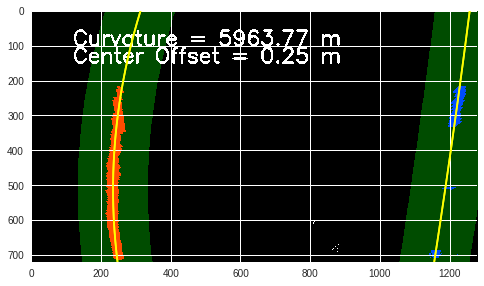

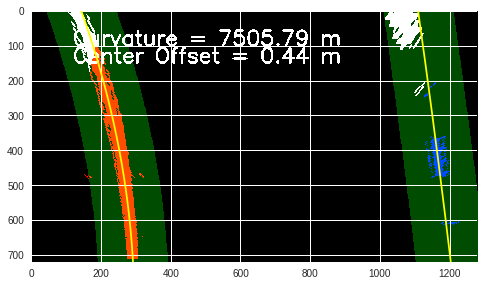

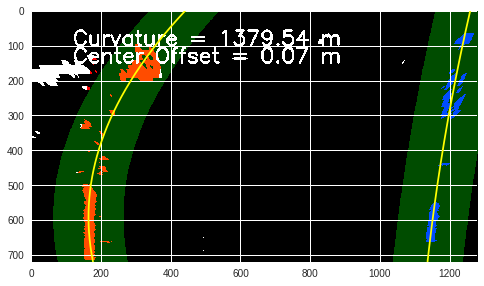

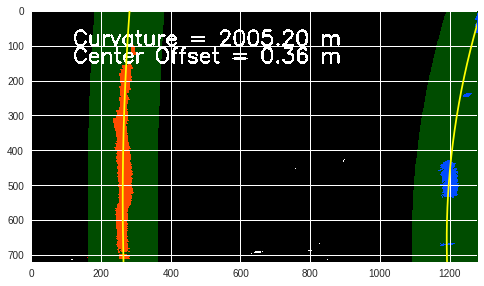

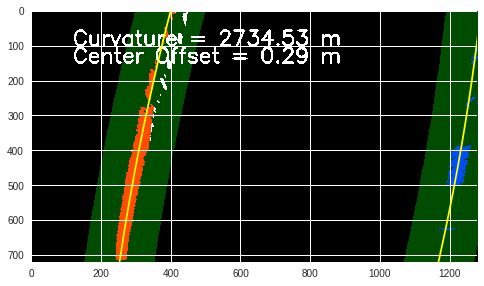

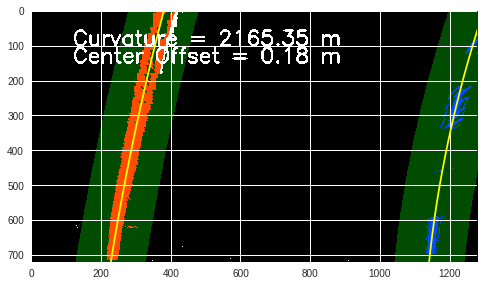

<Figure size 576x396 with 0 Axes>

In [0]:
lane_lines,left_fit,right_fit = fit_polynomial(warped_images[0])
#Fit polynomial and show lane lines
for img in warped_images:
    result,left_fitx,right_fitx = search_around_poly(img)
    result = draw_radius_curvature(result,result,left_fitx,right_fitx)    
    plt.imshow(result)
    plt.figure()

### Plot the detected lane boundaries on the original image

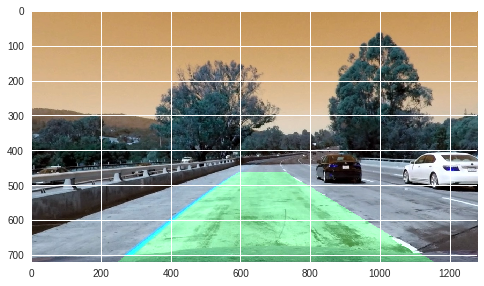

In [0]:
image = cv2.imread(F"{project_path}/test_images/test1.jpg")
warped = warped_images[0]
undist = undistort(image)

margin = 100

# Grab activated pixels
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
### Set the area of search based on activated x-values ###
### within the +/- margin of our polynomial function ###
    
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
        
# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit new polynomials
left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
        
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
#set source and destination points
src = np.float32([(203,720),(1099,720),(707,463),(580,463)])
dst = np.float32([(203,720),(1099,720),(1099,0),(203,0)])
        
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

### Some helper functions

In [0]:
def sliding_window(warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img,left_fit,right_fit,left_fitx,right_fitx,ploty

def sliding_window_from_prior(warped,left_best_fit, right_best_fit):
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    
    left_lane_inds = ((nonzerox > (left_best_fit[0]*(nonzeroy**2) + left_best_fit[1]*nonzeroy + 
                    left_best_fit[2] - margin)) & (nonzerox < (left_best_fit[0]*(nonzeroy**2) + 
                    left_best_fit[1]*nonzeroy + left_best_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_best_fit[0]*(nonzeroy**2) + right_best_fit[1]*nonzeroy + 
                    right_best_fit[2] - margin)) & (nonzerox < (right_best_fit[0]*(nonzeroy**2) + 
                    right_best_fit[1]*nonzeroy + right_best_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    ## End visualization steps ##
    
    return result,left_fit,right_fit,left_fitx,right_fitx,ploty

# Checking the lane values
def lane_accuracy(lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty):
    
    #Measuring Radius of Curvature for left and right lanes
    left_curverad = measure_curvature(left_fitx,lane_lines)
    right_curverad = measure_curvature(right_fitx,lane_lines)    
    average_curverad = (left_curverad + right_curverad)/2
    
    # meters per pixel in y dimension
    x_m_per_pix = 3.7/600
    
    mean_distance = np.mean(right_fitx - left_fitx) * x_m_per_pix
    
    lane_center = (left_fitx[-1] + right_fitx[-1]) // 2
    # Car center, Assuming the camera is mounted in the middle
    car_center = img.shape[1]/2
    # Calculate center offset
    center_offset = abs((lane_center - car_center) * x_m_per_pix)
    
    if mean_distance < 2.5 or mean_distance > 5:
        return False
    if center_offset > 0.5 or center_offset < -0.5 :
        return False
    
    # Checking radius
    
    if average_curverad < 30:
        return False
    if average_curverad > 1000:
        return False
    # Default value
    return True

def get_line_avg(prev_lines, new_line):    
    # Number of frames to average over
    num_frames = 25
    # if there is no new line
    if new_line is None:        
        if len(prev_lines) == 0:
            return previous_lines, None
        else:
            # Return previous line
            return prev_lines, prev_lines[-1]
    else:
        if len(prev_lines) < num_frames:
            # we need at least 10 frames to average over
            prev_lines.append(new_line)
            return prev_lines, new_line
        else:
            # average over the last 10 frames
            prev_lines[0:num_frames-1] = prev_lines[1:]
            prev_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += prev_lines[i]
            new_line /= num_frames
            return prev_lines,new_line

### Create pipeline to process images

In [0]:
left_best_fit = None
right_best_fit = None
prev_best_left_lines = []
prev_best_right_lines = []

def process_image(image):
    original_image = np.copy(image)
    
    #Undistort raw image
    undist = undistort(original_image)
    
    #Apply Threshold
    combined_binary = bin_threshold(undist)
    
    #Perform Perspective transform
    warped = pers(combined_binary)
    
    global left_best_fit
    global right_best_fit
    global prev_best_left_lines
    global prev_best_right_lines
    
    left_fit = None
    right_fit = None
        
    
    #if not left_line.detected or not right_line.detected:
    lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty = sliding_window(warped)
    
    if np.all(left_best_fit == None) or np.all(right_best_fit == None):
        lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty = sliding_window(warped)
    else:
        lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty = sliding_window_from_prior(warped,left_best_fit,right_best_fit)
        
        if left_fit is not None and right_fit is not None:
            if not lane_accuracy(lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty):
                lane_lines,left_fit,right_fit,left_fitx,right_fitx,ploty = sliding_window(warped)
    #  Add the values to the best fit array
    
     
    left_best_fit = left_fit
    right_best_fit = right_fit
    
    prev_best_left_lines,left_fitx = get_line_avg(prev_best_left_lines,left_fitx)
    prev_best_right_lines,right_fitx = get_line_avg(prev_best_right_lines,right_fitx)
    
    
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
    #set source and destination points
    src = np.float32([(203,720),(1099,720),(707,463),(580,463)])
    dst = np.float32([(203,720),(1099,720),(1099,0),(203,0)])

     
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    ##Draw Radius and Curvature information
    result = draw_radius_curvature(lane_lines,result,left_fitx,right_fitx)
    
    return result

### Run on Videos

In [0]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [0]:
output_path = F"{project_path}/project_video_output.mp4"
input_path = F"{project_path}/project_video.mp4"
clip1 = VideoFileClip(input_path)
clip = clip1.fl_image(process_image) 
%time clip.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video /content/gdrive/My Drive/Colab Notebooks/SDCND/P2-AdvancedLaneLines/project_video_output.mp4
[MoviePy] Writing video /content/gdrive/My Drive/Colab Notebooks/SDCND/P2-AdvancedLaneLines/project_video_output.mp4



 84%|████████▎ | 1056/1261 [21:07<04:14,  1.24s/it]